# QMSS G5055: Cloudburst Prediction Setup Guide

This notebook provides instructions for setting up a cloudburst prediction environment using Google Colab and reproducing a basic predictive model.

## 1. Setup in Google Colab

For simplicity, we'll use Google Colab directly without Docker:

In [ ]:
# Install required packages
!pip install pandas numpy matplotlib scikit-learn seaborn xarray netCDF4

## 2. Clone the Repository

In [ ]:
# Clone the repository
!git clone https://github.com/zaid-kamil/Cloudburst-Prediction-System.git
%cd Cloudburst-Prediction-System
!ls -la

Cloning into 'Cloudburst-Prediction-System'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 119 (delta 38), reused 88 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 24.80 MiB | 4.11 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (48/48), done.
/content/Cloudburst-Prediction-System/Cloudburst-Prediction-System
total 76
drwxr-xr-x 10 root root 4096 Feb 27 21:55 .
drwxr-xr-x 11 root root 4096 Feb 27 21:55 ..
drwxr-xr-x  6 root root 4096 Feb 27 21:55 data
drwxr-xr-x  2 root root 4096 Feb 27 21:55 docs
drwxr-xr-x  8 root root 4096 Feb 27 21:55 .git
-rw-r--r--  1 root root 1003 Feb 27 21:55 .gitignore
-rw-r--r--  1 root root 1499 Feb 27 21:55 LICENSE
-rw-r--r--  1 root root 4696 Feb 27 21:55 Makefile
drwxr-xr-x  2 root root 4096 Feb 27 21:55 models
drwxr-xr-x  3 root root 4096 Feb 27 21:55 notebooks
-rw-r--r--  1 root root 2728 Feb 27 21:55

## 3. Create/Obtain Weather Data

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Check for existing CSV files
data_dir = "data/processed"
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
if csv_files:
    print(f"Using existing file: {csv_files[0]}")
    df = pd.read_csv(os.path.join(data_dir, csv_files[0]))
else:
    print("Creating synthetic weather dataset")
    # Create date range - hourly data for one year
    start_date = datetime(2020, 1, 1)
    dates = [start_date + timedelta(hours=i) for i in range(8760)]

    # Generate weather data
    np.random.seed(42)
    temperature = np.random.normal(25, 5, len(dates))
    humidity = np.random.normal(70, 15, len(dates))
    pressure = np.random.normal(1013, 5, len(dates))
    wind_speed = np.random.exponential(5, len(dates))
    precipitation = np.random.exponential(1, len(dates))

    # Add cloudburst events (precipitation > 100mm/hour)
    cloudburst_indices = np.random.choice(len(dates), 20, replace=False)
    for idx in cloudburst_indices:
        precipitation[idx] = np.random.uniform(100, 150)
        humidity[idx] = min(100, humidity[idx] + np.random.uniform(10, 20))
        pressure[idx] = max(995, pressure[idx] - np.random.uniform(5, 15))

    # Create dataframe
    df = pd.DataFrame({
        'DATE': dates,
        'TEMP': temperature,
        'HUMIDITY': humidity,
        'PRESSURE': pressure,
        'WIND_SPEED': wind_speed,
        'PRECIP': precipitation
    })

    # Save to CSV
    df.to_csv('synthetic_weather_data.csv', index=False)

df.head()

Creating synthetic weather dataset


,DATE,TEMP,HUMIDITY,PRESSURE,WIND_SPEED,PRECIP
0,2020-01-01 00:00:00,27.483571,84.571185,1013.601750,5.817368,0.533317
1,2020-01-01 01:00:00,24.308678,50.571121,1016.602284,7.142359,1.317921
2,2020-01-01 02:00:00,28.238443,52.186702,1008.707069,9.645200,1.221469
3,2020-01-01 03:00:00,32.615149,78.683647,1021.477579,6.809809,3.369483
4,2020-01-01 04:00:00,23.829233,69.034935,1002.764166,12.405653,0.211834


## 4. Create Cloudburst Column

In [ ]:
# Create cloudburst column (precipitation > 100mm/hour)
precipitation_columns = [col for col in df.columns if any(keyword in col.upper() for keyword in ['PRECIP', 'RAIN', 'PPT'])]
if precipitation_columns:
    precip_col = precipitation_columns[0]
    df['CLOUDBURST'] = (df[precip_col] >= 100).astype(int)
    print(f"Number of cloudburst events: {df['CLOUDBURST'].sum()}")
    print(f"Percentage: {df['CLOUDBURST'].sum()/len(df)*100:.2f}%")
    # Display sample of cloudburst events
    df[df['CLOUDBURST'] == 1].head()

Number of cloudburst events: 20
Percentage: 0.23%


## 5. Preprocess Data for Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Process datetime features if available
date_columns = [col for col in df.columns if any(keyword in col.upper() for keyword in ['DATE', 'TIME'])]
if date_columns:
    date_col = date_columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    df['hour'] = df[date_col].dt.hour
    df['day'] = df[date_col].dt.day
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year

# Select numerical features for the model
features = df.select_dtypes(include=['number']).columns.tolist()
if 'CLOUDBURST' in features:
    features.remove('CLOUDBURST')
if precipitation_columns and precipitation_columns[0] in features:
    features.remove(precipitation_columns[0])

# Prepare data for modeling
df_model = df[features + ['CLOUDBURST']].copy()
df_model = df_model.fillna(df_model.median())

# Split features and target
X = df_model[features]
y = df_model['CLOUDBURST']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (7008, 8), Testing set: (1752, 8)


## 6. Build Basic Models


===== Logistic Regression Model Evaluation =====

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1747
           1       0.02      0.80      0.05         5

    accuracy                           0.91      1752
   macro avg       0.51      0.85      0.50      1752
weighted avg       1.00      0.91      0.95      1752



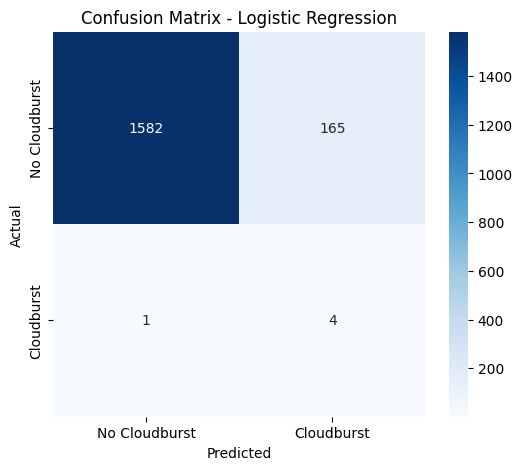


===== Random Forest Model Evaluation =====

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1747
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1752
   macro avg       0.50      0.50      0.50      1752
weighted avg       0.99      1.00      1.00      1752



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


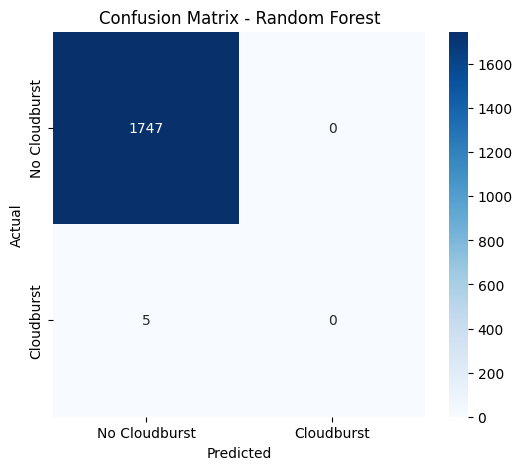

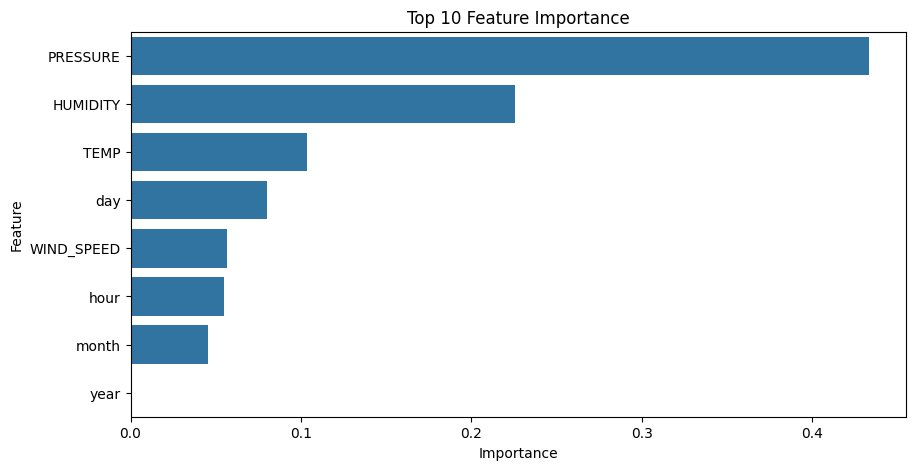

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train models
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Evaluate models
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model
}

for name, model in models.items():
    print(f"\n===== {name} Model Evaluation =====")

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Cloudburst', 'Cloudburst'],
                yticklabels=['No Cloudburst', 'Cloudburst'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Feature importance (for Random Forest)
    if 'Random Forest' in name:
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        plt.figure(figsize=(10, 5))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
        plt.title('Top 10 Feature Importance')
        plt.show()

## 7. Save the Model

In [ ]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the random forest model
with open('models/cloudburst_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save the scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the feature list
with open('models/features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Model and assets saved in the 'models' directory")

Model and assets saved in the 'models' directory


## 8. Function to Make Predictions

In [ ]:
def predict_cloudburst(data):
    """Make cloudburst predictions using the trained model"""
    # Load model, scaler, and features
    with open('models/cloudburst_rf_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('models/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('models/features.pkl', 'rb') as f:
        features = pickle.load(f)

    # Prepare data for prediction
    # Check if all features are present
    missing_features = [f for f in features if f not in data.columns]
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        return None

    # Select features and handle missing values
    X_pred = data[features].fillna(data[features].median())

    # Scale features and make predictions
    X_pred_scaled = scaler.transform(X_pred)
    predictions = model.predict(X_pred_scaled)
    probabilities = model.predict_proba(X_pred_scaled)[:, 1]

    # Add predictions to data
    result = data.copy()
    result['cloudburst_prediction'] = predictions
    result['cloudburst_probability'] = probabilities

    return result

# Test the prediction function
sample_data = df.iloc[:5].copy()
predicted_data = predict_cloudburst(sample_data)
if predicted_data is not None:
    predicted_data[['DATE', 'TEMP', 'PRECIP', 'cloudburst_prediction', 'cloudburst_probability']]

## Next Steps

1. Experiment with different features and feature engineering
2. Try more advanced models (XGBoost, Neural Networks)
3. Integrate real weather data from NOAA, NASA, etc.
4. Implement time-series forecasting for 4-6 hour prediction window
5. Add geographic features for more precise predictions